In [1]:
from tensorflow_probability import edward2 as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist

#from mpl_toolkits.mplot3d import Axes3D

import inferpy as inf 
from inferpy.datasets import mnist

print("InferPy "+ inf.__version__+" loaded")

%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


InferPy 1.0.0 loaded


In [2]:
from tensorflow_probability import edward2 as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# global parameters
elbo_evolution = {}
num_epochs = 1500

# Global configuration
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01

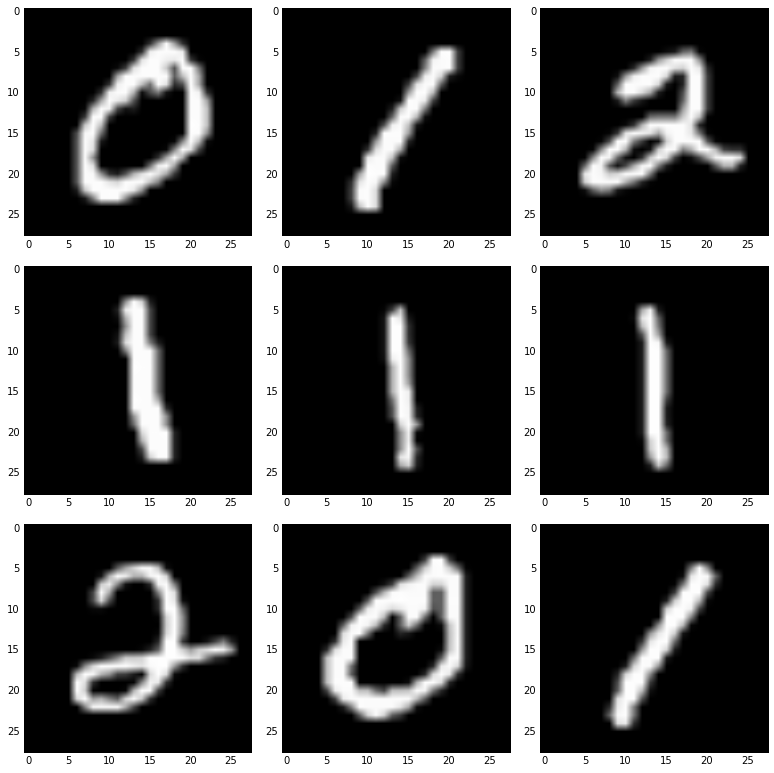

In [3]:
N = 1000                    #total number of observations    
num_pixels = 28*28          # pixels per image
ndigits=3
C = list(range(0, ndigits))       # digits considered

(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=C)

mnist.plot_digits(x_train)

In [4]:
# Model constants
k, d0, dx = 2, 100, num_pixels

# initial values
scale_epsilon = 0.01

In [5]:
@inf.probmodel
def vae(k, d0, dx, decoder):
    with inf.datamodel():
        z = inf.Normal(tf.ones([k])*0.5, 1., name="z")    # shape = [N, k]
        output = decoder(z,d0,dx)
        x_loc = output[:,:dx]
        x_scale = tf.nn.softmax(output[:,dx:]) + scale_epsilon
        x = inf.Normal(x_loc, x_scale, name="x")   # shape = [N,d]


def decoder(z,d0,dx):   # k -> d0 -> 2*dx
    h0 = tf.layers.dense(z, d0, tf.nn.relu)
    return tf.layers.dense(h0, 2 * dx)


# Q-model  approximating P
def encoder(x,d0, k): # dx -> d0 -> 2*k
    h0 = tf.layers.dense(x, d0, tf.nn.relu)
    return tf.layers.dense(h0, 2*k)

@inf.probmodel
def qmodel(k, d0, dx, encoder):
    with inf.datamodel():
        x = inf.Normal(tf.ones([dx]),1,name="x")

        output = encoder(x, d0, k)
        qz_loc = output[:, :k]
        qz_scale = tf.nn.softmax(output[:, k:]) + scale_epsilon

        qz = inf.Normal(qz_loc, qz_scale, name="z")
        
   

In [6]:
m = vae(k,d0,dx, decoder)
q = qmodel(k,d0,dx,encoder)  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [11]:
# set the inference algorithm
VI = inf.inference.SVI(q, epochs=1500, batch_size=100)

# learn the parameters
m.fit({"x": x_train}, VI)


 0 epochs	 271828860928.0.....

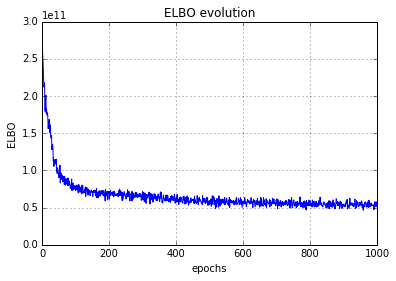

In [18]:
L = VI.debug.losses
plt.plot(range(len(L)), L)


plt.xlabel('epochs')
plt.ylabel('ELBO')
plt.title('ELBO evolution')
plt.grid(True)
plt.show()

In [9]:
# Importante: asociar metadatos a las RV dentro del modelo (tyoe o kind, indicando si es global parameter, local hidden...)
# Y si es MCMC? Hay q? Las queries tienen el mismo sentido?


In [19]:
postz = m.posterior('z', {'x': x_train[:100]}).sample()

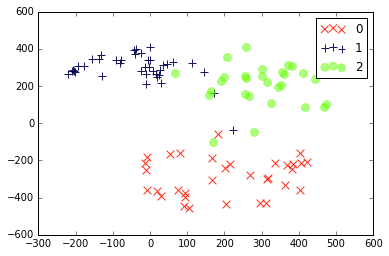

In [20]:
markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(C)):
    col = colors[c]
    plt.scatter(postz[y_train[:100] == C[c], 0], postz[y_train[:100] == C[c], 1], color=col,
                label=C[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()
###

/Users/jcozar/dev/almeria/inferPy/InferPy/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


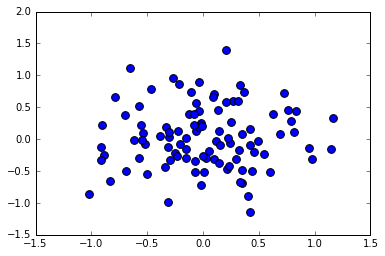

In [23]:
# Ahora igual pero sin fijar la x a x_train

fig = plt.figure()

postz = m.posterior('z').sample()

plt.scatter(postz[:,0], postz[:,1], s=60)
plt.legend()

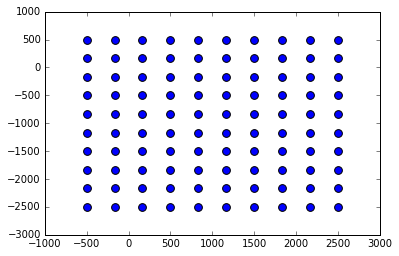

In [24]:
# define the range for both axis
xaxis = [-500, 2500]
yaxis = [500, -2500]


# generate 10x10 samples uniformly distributed, and get the first 1000
x = np.linspace(*xaxis, 10)
y = np.linspace(*yaxis, 10)
xx, yy = np.meshgrid(x, y)

postz = np.concatenate([np.expand_dims(xx.flatten() ,1), np.expand_dims(yy.flatten(), 1)], axis=1)[:100]

plt.scatter(postz[:,0], postz[:,1], s=60)
plt.legend()

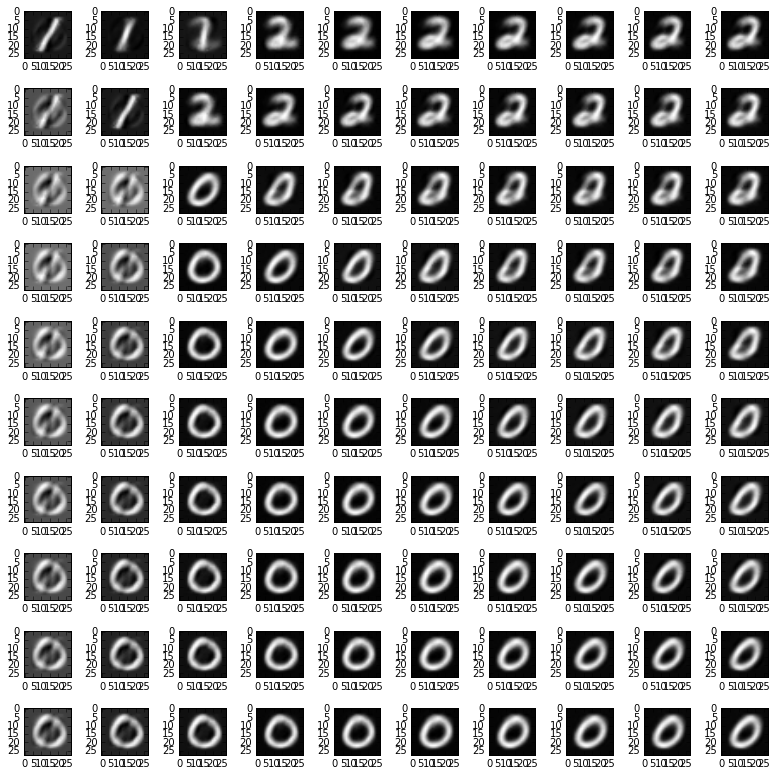

In [27]:
postx = m.posterior_predictive('x', {"z": postz}).sample()  # using posterior z
mnist.plot_digits(postx, [10, 10])

In [39]:
# generamos numeos NUM
NUM = 2
sess = inf.get_session()
postz = m.posterior('z', {"x": np.tile(x_train[y_train == NUM], [4,1])[:100]}).sample()

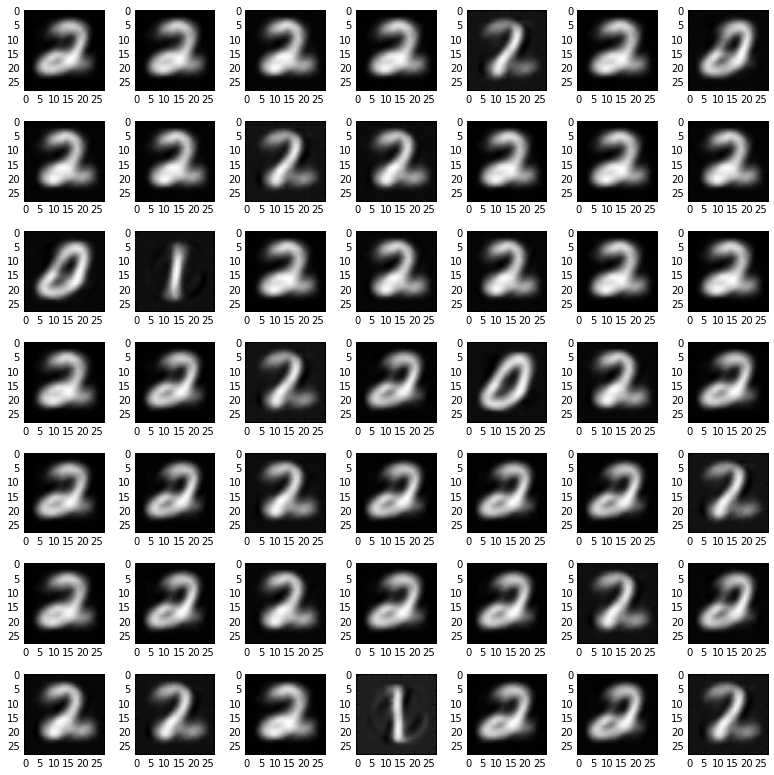

In [40]:
postx = m.posterior_predictive('x', {"z": postz}).sample()  # using posterior z
mnist.plot_digits(postx, [7, 7])

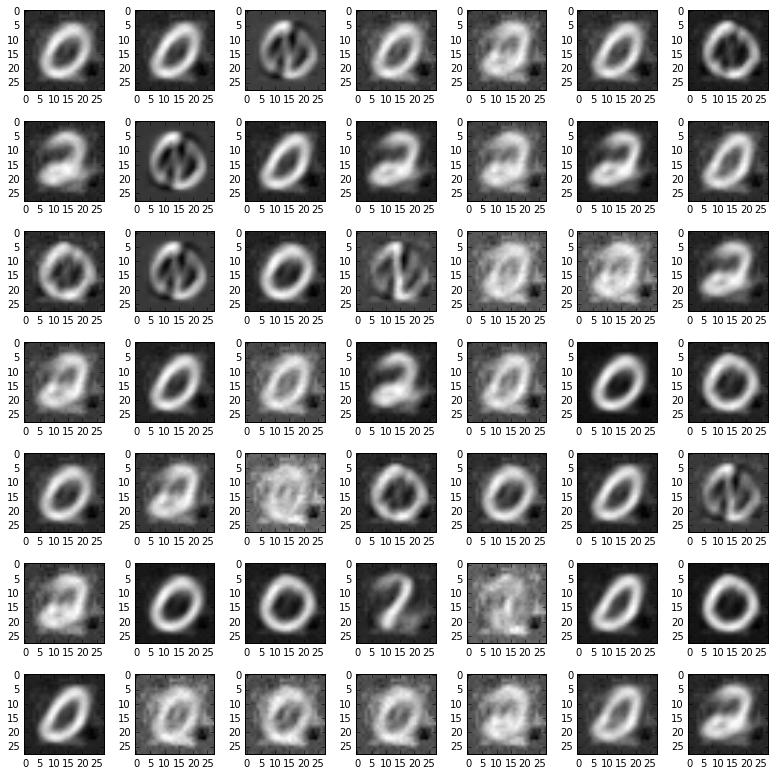

In [41]:
postx = m.posterior_predictive('x').sample()  # using posterior z
mnist.plot_digits(postx, [7, 7])

In [ ]:
# NOTA: usar un slider para mostrar el decodificar cada representacion de la z usando una de las herramientas de graphviz
